In [1]:
%matplotlib inline

# Import libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Global configuration
sns.set()
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/' #To avoid msg "ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH"

In [3]:
# Define global variables
SEED = 123
#suptitle_param = dict(color='darkblue', fontsize=11)
title_param = {'color': 'darkred', 'fontsize': 12}

In [4]:
# Read data
boston_data = pd.read_csv("boston.csv")
print(boston_data.head())
#print(boston_data.info())

      CRIM    ZN  INDUS  CHAS     NX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [5]:
# Read data
iowa_df = pd.read_csv("ames_housing_trimmed_processed.csv")
print(iowa_df.head())
#print(iowa_df.info())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   Remodeled  GrLivArea  BsmtFullBath  BsmtHalfBath  ...  HouseStyle_1.5Unf  \
0          0       1710             1             0  ...                  0   
1          0       1262             0             1  ...                  0   
2          1       1786             1             0  ...                  0   
3          1       1717             1             0  ...                  0   
4          0       2198             1             0  ...                  0   

   HouseStyle_1Story  HouseStyle_2.5Fin  HouseStyle_2.5Unf  HouseSty

# 2. Regression with XGBoost

After a brief review of supervised regression, you'll apply XGBoost to the regression task of predicting house prices in Ames, Iowa. You'll learn about the two kinds of base learners that XGboost can use as its weak learners, and review how to evaluate the quality of your regression models.

## 2.1 Regression review

1. Regression review
>Congratulations on finishing chapter 1! Now that you've learned how to use XGBoost for classification, you'll learn how to use XGBoost for regression in this chapter.

2. Regression basics
>Regression problems involve predicting continuous, or real, values. For example, if you're attempting to predict the height in centimeters a given person will be at 30 given some of their physical attributes at birth, you're solving a regression problem. Evaluating the quality of a regression model involves using a different set of metrics than those we described for use in classification problems in chapter 1.

3. Common regression metrics
>In most cases, we use root mean squared error (RMSE) or the mean absolute error (MAE) to evaluate the quality of a regression model.

4. Computing RMSE
>RMSE is computed by

5. Computing RMSE
>taking the difference between the actual and the predicted values for what you are trying to predict,

6. Computing RMSE
>squaring those differences, computing their mean, and taking that value's square root. This allows us to treat negative and positive differences equally, but tends to punish larger differences between predicted and actual values much more than smaller ones. MAE, on the other hand,

7. Computing MAE
>simply sums the absolute differences between predicted and actual values across all of the samples we build our model on. Although MAE isn't affected by large differences as much as RMSE, it lacks some nice mathematical properties that make it much less frequently used as an evaluation metric.

8. Common regression algorithms
>Some common algorithms that are used for regression problems include linear regression and decision trees. It's important to briefly note here that some algorithms,

9. Algorithms for both regression and classification
>such as decision trees, can be used for both regression as well as classification tasks, which, as we will see, is one of their important properties that makes them prime candidates to be building blocks for XGBoost models.
<br><br>https://www.ibm.com/support/knowledgecenter/en/SS3RA7_15.0.0/com.ibm.spss.modeler.help/nodes_treebuilding.htm

10. Let's practice!
>Awesome, let's test your regression knowledge with a multiple choice questions.

### Remarkable:

- Common metrics for regression models:
    * Root mean squared error (RMSE). Computed by taking the difference between the actual and the predicted values. But tend to punish larger differences much more than smaller ones.
    * Mean absolute error (MAE). Sums the absolute differences. Less frequency use.

- Common regression algorithms:
    * Linear regression
    * Decision tree

## 2.2 Which of these is a regression problem?

**Instructions**

Here are 4 potential machine learning problems you might encounter in the wild. Pick the one that is a clear example of a regression problem.

**Possible Answers**

1. Recommending a restaurant to a user given their past history of restaurant visits and reviews for a dining aggregator app.
2. Predicting which of several thousand diseases a given person is most likely to have given their symptoms.
3. Tagging an email as spam/not spam based on its content and metadata (sender, time sent, etc.).
4. <font color=red>Predicting the expected payout of an auto insurance claim given claim properties (car, accident type, driver prior history, etc.)</font>. **Correct!**.

**Results**

<font color=darkgreen>Well done! This is indeed an example of a regression problem.</font>

## 2.3 Objective (loss) functions and base learners

1. Objective (loss) functions and base learners
>Let's talk a bit about objective functions and base learners so we can develop better intuitions about both concepts, as they are critical to understand in order for you to be able to grasp why XGBoost is such a powerful approach to building supervised regression models.

2. Objective Functions and Why We Use Them
>An objective or loss function quantifies how far off our prediction is from the actual result for a given data point. It maps the difference between the prediction and the target to a real number. When we construct any machine learning model, we do so in the hopes that it minimizes the loss function across all of the data points we pass in. That's our ultimate goal, the smallest possible loss.

3. Common loss functions and XGBoost
>Loss functions have specific naming conventions in XGBoost. For regression models, the most common loss function used is called reg linear. For binary classification models, the most common loss functions used are reg logistic, when you simply want the category of the target, and binary logistic, when you want the actual predicted probability of the positive class. So, in chapter 1, we were implicitly using the reg logistic loss function when building our classification models in XGBoost.

4. Base learners and why we need them
>As mentioned before, XGBoost is an ensemble learning method composed of many individual models that are added together to generate a single prediction. Each of the individual models that are trained and combined are called base learners. The goal of XGBoost is to have base learners that is slightly better than random guessing on certain subsets of training examples, and uniformly bad at the remainder, so that when all of the predictions are combined, the uniformly bad predictions cancel out and those slightly better than chance combine into a single very good prediction. Let's look at a couple examples using trees and linear base learners in XGBoost.

5. Trees as base learners example: Scikit-learn API
>Here's an example of how to train an XGBoost regression model with trees as base learners using XGBoost's scikit-learn compatible API. We will use the Boston Housing dataset from UCI's machine learning repository as an example. In lines 1-5 we import the libraries we need and load in the data. In lines 6 and 7, we convert our data into our X matrix and y vector and split into training and test sets as we've done before. In lines 8-10, we create our XGBoost regressor object, this time making sure we use the reg linear objective function, fit it to our training data, and generate our predictions on the test set.

6. Trees as base learners example: Scikit-learn API
>And finally in lines 11 and 12 we compute the RMSE and print the result to screen.

7. Linear base learners example: learning API only
>To use linear base learners, we have to use the learning API in XGBoost. Here's an example. In lines 1-7 we do what we did as before, loading in appropriate libraries and data. In lines 8 and 9 we convert our training and testing sets into DMatrix objects, as is required by the learning API. In line 10 we create a parameter dictionary explicitly specifying the base learner we want as gblinear, and the reg linear objective function we want to use. In lines 11-12 we train our model on the training set and generate predictions using the test set.

8. Linear base learners example: learning API only
>In lines 13 and 14, we compute our rmse and print to screen, as we did before.

9. Let's get to work!
>Ok, lets get to work!

### Most common loss functions:
- Regression models $\rightarrow$ reg:linear
- Binary Classification models:
    * $\rightarrow$ reg:logistic for only get the categorical target
    * $\rightarrow$ binary:logistic for predicted probability of the classes

In [6]:
# Trees as base learners example: Scikit-learn API
X, y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=SEED)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=SEED)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,preds))
print("Tree as base learnesrs - RMSE: %f" % (rmse))

Tree as base learnesrs - RMSE: 3.782443


In [7]:
# Linear base learners example: learning API only
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test = xgb.DMatrix(data=X_test,label=y_test)

params = {"booster":"gblinear","objective":"reg:squarederror", 'seed':SEED}

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)

rmse = np.sqrt(mean_squared_error(y_test,preds))
print("Linear as base learners - RMSE: %f" % (rmse))

Linear as base learners - RMSE: 6.451762


## 2.4 Decision trees as base learners

It's now time to build an XGBoost model to predict house prices - not in Boston, Massachusetts, as you saw in the video, but in Ames, Iowa! This dataset of housing prices has been pre-loaded into a DataFrame called df. If you explore it in the Shell, you'll see that there are a variety of features about the house and its location in the city.

In this exercise, your goal is to use trees as base learners. By default, XGBoost uses trees as base learners, so you don't have to specify that you want to use trees here with booster="gbtree".

xgboost has been imported as xgb and the arrays for the features and the target are available in X and y, respectively.

**Instructions**

1. Split df into training and testing sets, holding out 20% for testing. Use a random_state of 123.
2. Instantiate the XGBRegressor as xg_reg, using a seed of 123. Specify an objective of "reg:linear" and use 10 trees. Note: You don't have to specify booster="gbtree" as this is the default.
3. Fit xg_reg to the training data and predict the labels of the test set. Save the predictions in a variable called preds.
4. Compute the rmse using np.sqrt() and the mean_squared_error() function from sklearn.metrics, which has been pre-imported.

**Results**

<font color=darkgreen>Well done! Next, you'll train an XGBoost model using linear base learners and XGBoost's learning API. Will it perform better or worse?</font>

In [8]:
# Create arrays for the features and the target: X, y
X, y = iowa_df.iloc[:,:-1],iowa_df.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(booster="gbtree", # Default value, it is not necessary to specify. 
                          objective='reg:squarederror', n_estimators=10, seed=SEED)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 28106.463641


## 2.5 Linear base learners

Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train().

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in Chapter 1 when you used xgb.cv()). The key-value pair that defines the booster type (base model) you need is "booster":"gblinear".

Once you've created the model, you can use the .train() and .predict() methods of the model just like you've done in the past.

Here, the data has already been split into training and testing sets, so you can dive right into creating the DMatrix objects required by the XGBoost learning API.

**Instructions**

1. Create two DMatrix objects - DM_train for the training set (X_train and y_train), and DM_test (X_test and y_test) for the test set.
2. Create a parameter dictionary that defines the "booster" type you will use ("gblinear") as well as the "objective" you will minimize ("reg:linear").
3. Train the model using xgb.train(). You have to specify arguments for the following parameters: params, dtrain, and num_boost_round. Use 5 boosting rounds.
4. Predict the labels on the test set using xg_reg.predict(), passing it DM_test. Assign to preds.
5. Hit 'Submit Answer' to view the RMSE!

**Results**

<font color=darkgreen>Interesting - it looks like linear base learners performed better! $\leftarrow$ Not true in local machine</font>

In [9]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test =  xgb.DMatrix(data = X_test, label = y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror", 'seed':SEED}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain = DM_train, num_boost_round = 10)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 39952.367262


## 2.6 Evaluating model quality

It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the Ames housing data. As in previous exercises, all necessary modules have been pre-loaded and the data is available in the DataFrame df.

**Instructions**

1. Perform 4-fold cross-validation with 5 boosting rounds and "rmse" as the metric.
2. Extract and print the final boosting round RMSE.

3. Now, adapt your code to compute the "mae" instead of the "rmse".

**Results**

<font color=darkgreen>Great work!</font>

In [10]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, 
                    params=params, nfold=4, num_boost_round=5, 
                    metrics='rmse', as_pandas=True, 
                    seed=SEED)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print('RMSE: %f' % (cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.535156      429.451316   142980.433594    1193.791602
1    102832.542969      322.473304   104891.392578    1223.157623
2     75872.617188      266.469946    79478.939454    1601.341377
3     57245.650390      273.623926    62411.921875    2220.149857
4     44401.298828      316.423666    51348.281250    2963.378741
RMSE: 51348.281250


In [11]:
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, 
                    params=params, nfold=4, num_boost_round=5, 
                    metrics='mae', as_pandas=True, 
                    seed=SEED)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print('MAE: %f' % (cv_results["test-mae-mean"]).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.480469     668.337982  127633.972657   2404.002681
1    89770.052735     456.957620   90122.501953   2107.912682
2    63580.790039     263.405712   64278.563477   1887.565119
3    45633.153321     151.884551   46819.166016   1459.819398
4    33587.093750      86.999137   35670.645508   1140.606558
MAE: 35670.645508


## 2.7 Regularization and base learners in XGBoost

1. Regularization and base learners in XGBoost
>Loss functions in XGBoost don't just take into account how close a model's predictions are to the actual values,

2. Regularization in XGBoost
>but also take into account how complex the model is. This idea of penalizing models as they become more complex is called regularization. So, loss functions in XGBoost are used to find models that are both accurate and as simple as they can possibly be. There are several parameters that can be tweaked in XGBoost to limit model complexity by altering the loss function. Gamma is a parameter for tree base learners that controls whether a given node on a base learner will split based on the expected reduction in the loss that would occur after performing the split, so that higher values lead to fewer splits. Alpha is another name for L1 regularization. However, this regularization term is a penalty on leaf weights rather than on feature weights, as is the case in linear or logistic regression. Higher alpha values lead to stronger L1 regularization, which causes many leaf weights in the base learners to go to 0. Lambda is another name for l2 regularization. L2 regularization is a much smoother penalty that l1 and causes leaf weights to smoothly decrease, instead of enforcing strong sparsity constraints on the leaf weights as in l1. If you're interested in learning more about regularization, check out DataCamp's Supervised Learning With Scikit Learn Course.

3. L1 regularization in XGBoost example
>Let's look at an example of how you can tune one of these regularization parameters using XGBoost. As always, in lines 1-4 we import the necessary libraries, load in the data we will be working with, and create our feature matrix and target vectors X and y. In line 5 we convert our X matrix and y vector into a single optimized DMatrix object, and in line 6 we create our parameter dictionary that defines some required parameters for our learner. Specifically, we provide the loss function necessary for regression, and the maximum depth each tree base learner can have. In line 7 we create a list of 3 different l1 or alpha values that we will try, and in line 8 we initialize an empty list that will store our final root mean square error for each of these l1 or alpha values. Line 9 is actually a multi-line for loop where we iterate over each entry in our l1_params list and do the following. First, we create a new key-value pair in our parameter dictionary that holds our current alpha value. We then run our XGBoost cross validation by passing in our DMatrix object, updated parameter dictionary, number of folds we want to cross-validate, number of trees we want as num_boost_round, the metric we want to compute, which is rmse, and that we want to output the results as a pandas DataFrame. In lines 10 and 11, we simply look at the final RMSE as a function of l1 regularization strength. At this point, we've talked about

4. Base learners in XGBoost
>base learners and regularization quite a bit. Let's finish this off by comparing the two kinds of base learners that exist in XGBoost. The linear base learner is simply a sum of linear terms, exactly as you would find in a linear or logistic regression model. When you combine many of these base models into an ensemble, you get a weighted sum of linear models, which is itself linear. Since you don't get any nonlinear combination of features in the final model, this approach is rarely used, as you can get identical performance from a regularized linear model. The tree base learner uses decision trees as base models. When the decision trees are all combined into an ensemble, their combination becomes a nonlinear function of each individual tree, which itself is nonlinear. At this point, I want to briefly mention how you'll see

5. Creating DataFrames from multiple equal-length lists
>Dataframes being created in the next couple exercises after you've computed your results. We will use both the zip and list function, one inside of the other, to convert multiple equal-length lists into a single object that we can convert into a pandas dataframe. Zip is a function that allows you to take multiple equal-length lists and iterate over them in parallel, side by side, as shown above. However, in python 3, zip creates a generator, or an object that doesn't have to be completely instantiated at runtime. In order for the entire zipped pair of lists to be instantiated, we have to cast the zip generator object into a list directly. After casting, we can convert this object directly into a dataframe. The point of all of this is, don't feel overwhelmed when you see this pattern in the following exercises, as its very useful and will only make you a stronger Python programmer and data scientist.

6. Let's practice!
>Now, it's your turn to perform l2 regularization with an XGBoost model in the following exercises. In addition, you'll learn how to visualize feature importances in your model.

### Regularization in XGBoost

- gamma (tree base learners' parameter): controls whether a given node on a base learner will split based on the expected reduction in the loss function. Higher values lead to fewer splits.
- alpha (L1 regularization): is a penaltty on leaf weights, rather on feature weights (as in the case in linear or logistic regression). Higher values lead to stronger regularization, causing many leaf weights in the base learners to go to 0.
- lambda (L2 regularization): causes leaf weights to smoothly decrease, instead of enforcing strong sparsity constraints on the leaf weights as in L1.

In [12]:
# L1 regularization in XGBoost example

X,y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]

boston_dmatrix = xgb.DMatrix(data=X,label=y)

params    = {"objective":"reg:squarederror","max_depth":4}
l1_params = [0.1, 0.5, 0.9, 0.95, 1, 1.05, 3, 5, 10,100]
rmses_l1  = []

for reg in l1_params:
    params["alpha"] = reg
    
    cv_results = xgb.cv(dtrain          = boston_dmatrix, 
                        params          = params,
                        nfold           = 4,
                        num_boost_round = 10,
                        metrics         = "rmse",
                        as_pandas       = True,
                        seed            = SEED)
    
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(l1_params,rmses_l1)), columns=["l1","rmse"]))

Best rmse as a function of l1:
       l1      rmse
0    0.10  3.545175
1    0.50  3.565448
2    0.90  3.450161
3    0.95  3.450803
4    1.00  3.461474
5    1.05  3.470308
6    3.00  3.518848
7    5.00  3.581654
8   10.00  3.821152
9  100.00  4.645518


## 2.8 Using regularization in XGBoost

Having seen an example of l1 regularization in the video, you'll now vary the l2 regularization penalty - also known as "lambda" - and see its effect on overall model performance on the Ames housing dataset.

**Instructions**

1. Create your DMatrix from X and y as before.
2. Create an initial parameter dictionary specifying an "objective" of "reg:linear" and "max_depth" of 3.
3. Use xgb.cv() inside of a for loop and systematically vary the "lambda" value by passing in the current l2 value (reg).
4. Append the "test-rmse-mean" from the last boosting round for each cross-validated xgboost model.
5. Hit 'Submit Answer' to view the results. What do you notice?

**Results**

<font color=darkgreen>Nice work! It looks like as as the value of 'lambda' increases, so does the RMSE.</font>

In [13]:
# Create arrays for the features and the target: X, y
X, y = iowa_df.iloc[:,:-1],iowa_df.iloc[:,-1]

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [0.1, 0.5, 0.9, 0.95, 1, 1.05, 3, 5, 10,100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":4}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, 
                             params=params, 
                             nfold=4, 
                             num_boost_round=10, 
                             metrics="rmse", 
                             as_pandas=True, 
                             seed=SEED)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
       l2          rmse
0    0.10  34478.415039
1    0.50  34489.837891
2    0.90  35711.421387
3    0.95  35389.071778
4    1.00  35572.511719
5    1.05  35253.532227
6    3.00  35418.582031
7    5.00  36711.918946
8   10.00  38721.587890
9  100.00  47549.375977


## 2.9 Visualizing individual XGBoost trees

Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.

XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

**Instructions**

1. Create a parameter dictionary with an "objective" of "reg:linear" and a "max_depth" of 2.
2. Train the model using 10 boosting rounds and the parameter dictionary you created. Save the result in xg_reg.
3. Plot the first tree using xgb.plot_tree(). It takes in two arguments - the model (in this case, xg_reg), and num_trees, which is 0-indexed. So to plot the first tree, specify num_trees=0.
4. Plot the fifth tree.
5. Plot the last (tenth) tree sideways. To do this, specify the additional keyword argument rankdir="LR".

**Results**

<font color=darkgreen>Excellent! Have a look at each of the plots. They provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions. This allows us to identify which features are the most important in determining house price. In the next exercise, you'll learn another way of visualizing feature importances.</font>

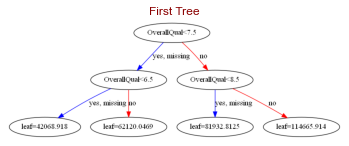

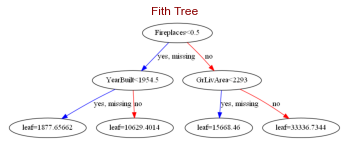

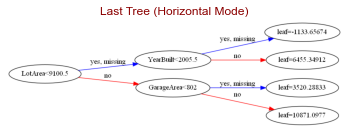

In [14]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"booster":"gbtree", # Default value, it is not necessary to specify.
          "objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.title('First Tree', **title_param)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.title('Fith Tree', **title_param)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
plt.title('Last Tree (Horizontal Mode)', **title_param)
plt.show()

## 2.10 Visualizing feature importances: What features are most important in my dataset

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this, and you'll get a chance to use it in this exercise!

**Instructions**

1. Create your DMatrix from X and y as before.
2. Create a parameter dictionary with appropriate "objective" ("reg:linear") and a "max_depth" of 4.
3. Train the model with 10 boosting rounds, exactly as you did in the previous exercise.
4. Use xgb.plot_importance() and pass in the trained model to generate the graph of feature importances.

**Results**

<font color=darkgreen>Brilliant! It looks like GrLivArea is the most important feature. Congratulations on completing Chapter 2!</font>

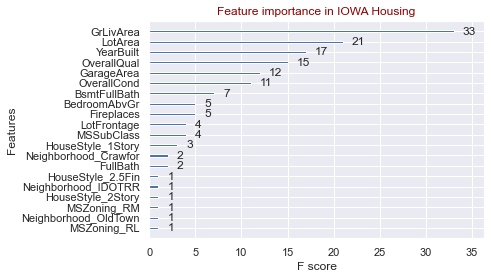

In [15]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.title('Feature importance in IOWA Housing', **title_param)
plt.show()

# Aditional material

- Datacamp course: https://learn.datacamp.com/courses/extreme-gradient-boosting-with-xgboost
- Xgboost documentation: https://xgboost.readthedocs.io/en/latest/
- sklearn.tree.DecisionTreeClassifier documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier